# Backstory_and_CharacterDesign_Generator_MortalKombat_Character

Import dependencies

In [70]:
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

In [71]:
# Function to run the model for creating character backstory
def run_sample_mkbackstory(myprompt):
    # -----------------------------------------------------------------------------
    init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
    out_dir = 'out-mk-src' # ignored if init_from is not 'resume'
    start = myprompt # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
    num_samples = 1 # number of samples to draw
    max_new_tokens = 200 # number of tokens generated in each sample
    temperature = 0.92 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
    top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
    seed = 1337
    device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
    dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
    compile = False # use PyTorch 2.0 to compile the model to be faster
    # exec(open('configurator.py').read()) # overrides from command line or config file
    # -----------------------------------------------------------------------------

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
    torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
    device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
    ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
    ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

    # model
    if init_from == 'resume':
        # init from a model saved in a specific directory
        ckpt_path = os.path.join(out_dir, 'ckpt.pt')
        checkpoint = torch.load(ckpt_path, map_location=device)
        gptconf = GPTConfig(**checkpoint['model_args'])
        model = GPT(gptconf)
        state_dict = checkpoint['model']
        unwanted_prefix = '_orig_mod.'
        for k,v in list(state_dict.items()):
            if k.startswith(unwanted_prefix):
                state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
        model.load_state_dict(state_dict)
    elif init_from.startswith('gpt2'):
        # init from a given GPT-2 model
        model = GPT.from_pretrained(init_from, dict(dropout=0.0))

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model) # requires PyTorch 2.0 (optional)

    # look for the meta pickle in case it is available in the dataset folder
    load_meta = False
    if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
        meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
        load_meta = os.path.exists(meta_path)
    if load_meta:
        print(f"Loading meta from {meta_path}...")
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        # TODO want to make this more general to arbitrary encoder/decoder schemes
        stoi, itos = meta['stoi'], meta['itos']
        encode = lambda s: [stoi[c] for c in s]
        decode = lambda l: ''.join([itos[i] for i in l])
    else:
        # ok let's assume gpt-2 encodings by default
        print("No meta.pkl found, assuming GPT-2 encodings...")
        enc = tiktoken.get_encoding("gpt2")
        encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
        decode = lambda l: enc.decode(l)

    # encode the beginning of the prompt
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
            
    # start_custom = "mortal kombat character's backstories of" + start
    start_ids = encode(start)
    # start_ids = encode(start_custom)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
                text = decode(y[0].tolist())
                with open("output/"+myprompt+".txt", "w") as file:
                    # Write the text to the file
                    file.write(text)

                print("Text saved to file.")
                print(text)
                print('---------------')
                
    return text
                

In [72]:
# Function to run the model for generating Open Journey prompt
def run_sample_ojprompt(myprompt):
    # -----------------------------------------------------------------------------
    init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
    out_dir = 'out-prompt' # ignored if init_from is not 'resume'
    start = myprompt # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
    num_samples = 1 # number of samples to draw
    max_new_tokens = 50 # number of tokens generated in each sample
    temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
    top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
    seed = 1337
    device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
    dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
    compile = False # use PyTorch 2.0 to compile the model to be faster
    # exec(open('configurator.py').read()) # overrides from command line or config file
    # -----------------------------------------------------------------------------

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
    torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
    device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
    ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
    ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

    # model
    if init_from == 'resume':
        # init from a model saved in a specific directory
        ckpt_path = os.path.join(out_dir, 'ckpt.pt')
        checkpoint = torch.load(ckpt_path, map_location=device)
        gptconf = GPTConfig(**checkpoint['model_args'])
        model = GPT(gptconf)
        state_dict = checkpoint['model']
        unwanted_prefix = '_orig_mod.'
        for k,v in list(state_dict.items()):
            if k.startswith(unwanted_prefix):
                state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
        model.load_state_dict(state_dict)
    elif init_from.startswith('gpt2'):
        # init from a given GPT-2 model
        model = GPT.from_pretrained(init_from, dict(dropout=0.0))

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model) # requires PyTorch 2.0 (optional)

    # look for the meta pickle in case it is available in the dataset folder
    load_meta = False
    if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
        meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
        load_meta = os.path.exists(meta_path)
    if load_meta:
        print(f"Loading meta from {meta_path}...")
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        # TODO want to make this more general to arbitrary encoder/decoder schemes
        stoi, itos = meta['stoi'], meta['itos']
        encode = lambda s: [stoi[c] for c in s]
        decode = lambda l: ''.join([itos[i] for i in l])
    else:
        # ok let's assume gpt-2 encodings by default
        print("No meta.pkl found, assuming GPT-2 encodings...")
        enc = tiktoken.get_encoding("gpt2")
        encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
        decode = lambda l: enc.decode(l)

    # encode the beginning of the prompt
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
            
    # start_custom = "mortal kombat character's backstories of" + start
    start_ids = encode(start)
    # start_ids = encode(start_custom)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
                text = decode(y[0].tolist())

                print("Text saved to file.")
                print(text)
                print('---------------')
    
    return text
                

### Start here: Create your character
Enter your character's name or characteristic

In [73]:
# Enter your prompt here
# Eg. "Lancelot" / "A swordking with hammer"
myprompt = "A snake with four arms"

In [74]:
# Generate backstory
backstory = run_sample_mkbackstory(myprompt)

number of parameters: 29.94M
No meta.pkl found, assuming GPT-2 encodings...
Text saved to file.
A snake with four arms. He has the remainder of his chi, Raiden has created a broken Fahrenheit which has also made him to convert it into a degree of Kun-freeze, kill the 2010 remake, but by Kamidogu daggers made him to life in the element of neutral because of his dream human form as he can support his family. Later, untrustworthy nature, Bo' Rai Cho has since lizards. Only Delia, becoming the late King Jerrod. 
After his debut, Quan Chi is a pure, Quan Chi is one of Outworld's greatest shame like Earth's wife. Throughout the Justice League when those descended from his skills of his overall threatening his own Earthrealm's skills as his origins have been a mysterious entities identified only. Related to his Bladed Glove, his reflection in a thorough guise to his wife. This, his name is an respiratory mask is an his father, his wife. In the epitome of his penchant for good, his former
----

In [75]:
# Generate prompt for creating image with
prompt = run_sample_ojprompt(myprompt)

number of parameters: 29.94M
No meta.pkl found, assuming GPT-2 encodings...
Text saved to file.
A snake with four arms, horns, and a pair of daggers. 
a vintage painting with no background, a person standing at a desk with a blank canvas, an illustration depicting a person standing on the phone, wearing a business suit, 
A cinematic landscape
---------------


In [76]:
from diffusers import StableDiffusionPipeline
import torch
import os

model_id = "prompthero/openjourney"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

folder_path = "output/"

image = pipe(prompt).images[0]
image.save(os.path.join(folder_path, myprompt + ".png"))


text_encoder\model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


## Character Design Output

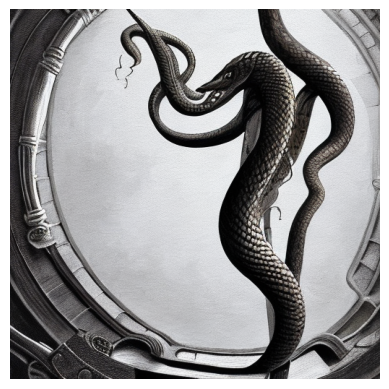

In [77]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image from file
image_path = "output/"+myprompt+".png" # Replace with the actual path to your image
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


## Character Backstory

In [78]:
import textwrap

# Wrap the text to a specific width
wrapped_text = textwrap.fill(backstory, width=80)

# Print the wrapped text
print(wrapped_text)


A snake with four arms. He has the remainder of his chi, Raiden has created a
broken Fahrenheit which has also made him to convert it into a degree of Kun-
freeze, kill the 2010 remake, but by Kamidogu daggers made him to life in the
element of neutral because of his dream human form as he can support his family.
Later, untrustworthy nature, Bo' Rai Cho has since lizards. Only Delia, becoming
the late King Jerrod.  After his debut, Quan Chi is a pure, Quan Chi is one of
Outworld's greatest shame like Earth's wife. Throughout the Justice League when
those descended from his skills of his overall threatening his own Earthrealm's
skills as his origins have been a mysterious entities identified only. Related
to his Bladed Glove, his reflection in a thorough guise to his wife. This, his
name is an respiratory mask is an his father, his wife. In the epitome of his
penchant for good, his former
